## Создание dwg файла с зонами армирования v0.1
### Основные этапы:
* Чтение asf файла
* Формирование геометрии плиты в dxf
* Вычитание фонового армирования
* Поиск самостоятельных зон армирования
* Нахождения их контура и запись в файл

### Константы

In [1]:
PATH_TO_ASF = r'../st4_task_fp_r01.asf'
NAME_COLUMNS_REINFORCE = ['x', 'y', 'z', 'top_x', 'top_y', 'top_z', 'bot_x', 'bot_y', 'bot_z']
DROP_COLUMNS_REINFORCE = ['z', 'top_z', 'bot_z']

REINFORCE_MAIN_TOP = 10.0
REINFORCE_MAIN_BOTTOM = 10.0

PATH_TO_SAVE_DXF = 'test_reinforce.dxf'

### Импорт

In [2]:
import alphashape
import ezdxf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy.spatial
from sklearn.cluster import DBSCAN

%matplotlib inline
plt.style.use(['seaborn', 'seaborn-paper'])

### Чтение asf файла

In [3]:
reinforces = []
slabs = []
slab_stack = []
is_read_slab = False

with open(PATH_TO_ASF) as f:
    for line in f:
        if line.strip():
            # Чтение армирования
            if line.startswith('QB'):
                numbers = [float(i)for i in line.split()[1:-1]]
                reinforces.append(numbers)

            # Начало чтения координат плиты
            elif line.startswith('GL'):
                is_read_slab = True
                slabs.append(slab_stack) if slab_stack else None
                slab_stack = []

            # Конец чтения координат плиты
            elif line.startswith('GP'):
                is_read_slab = False
                slabs.append(slab_stack) if slab_stack else None
                slab_stack = []

            # Запись координат плиты
            elif is_read_slab:
                coords = [float(i)*1000.0 for i in line.split()]
                slab_stack.append(coords)


print(f'Read {len(reinforces)} rows of reinforces')
print(f'Read {len(slabs)} rows of slabs')

Read 11656 rows of reinforces
Read 10 rows of slabs


### Формирование геометрию плиты

#### Создаем dxf файл

In [4]:
dxf_doc = ezdxf.new(dxfversion='R2010', setup=True)
dxf_doc.layers.new('boundary_slab', dxfattribs={'color': 3})
msp = dxf_doc.modelspace()

#### Записываем контуры плит

In [5]:
for slab in slabs:
    slab_convert = np.array(slab)[:, :-1]
    msp.add_lwpolyline(slab_convert, dxfattribs={'layer': 'boundary_slab', 'closed': True})

#### Изобразим контур плиты

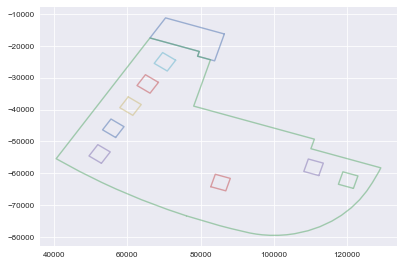

In [6]:
def print_slab(slabs_, ax_slab, color='any'):
    c = None if color =='any' else color
    for slab_ in slabs_:
        slab_convert_ = np.array([*slab_, slab_[0]])[:, :-1]
        ax_slab.plot(*slab_convert_.T, c=c, alpha=0.5)

fig, ax = plt.subplots()
print_slab(slabs, ax)
plt.show()

### Анализ арматуры
#### Создаем DataFrame

In [7]:
reinforces_df = pd.DataFrame(reinforces, columns=NAME_COLUMNS_REINFORCE)
reinforces_df.drop(columns=DROP_COLUMNS_REINFORCE, inplace=True)

# Преобразуем координаты
reinforces_df[['x', 'y']] = reinforces_df[['x', 'y']] * 1000.0

# Вычитаем основное армирование
reinforces_df[['top_x', 'top_y']] = reinforces_df[['top_x', 'top_y']] - REINFORCE_MAIN_TOP
reinforces_df[['bot_x', 'bot_y']] = reinforces_df[['bot_x', 'bot_y']] - REINFORCE_MAIN_BOTTOM
reinforces_df[reinforces_df[['top_x', 'top_y', 'bot_x', 'bot_y']] < 0] = None

print('Получаем следующий Dataframe')
reinforces_df

Получаем следующий Dataframe


,x,y,top_x,top_y,bot_x,bot_y
0,66170.0,-17522.0,NaN,NaN,NaN,NaN
1,66478.0,-17619.0,NaN,NaN,NaN,NaN
2,66555.0,-16953.0,NaN,NaN,NaN,NaN
3,67139.0,-16088.0,NaN,NaN,NaN,NaN
4,67453.0,-16187.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
11651,79358.0,-21671.0,4.57,NaN,8.60,10.88
11652,79548.0,-22086.0,0.96,0.13,12.13,11.85
11653,79320.0,-21953.0,5.53,NaN,11.72,13.94
11654,79649.0,-21763.0,0.08,4.38,7.91,12.04


#### Визуализируем дополнительное армирование

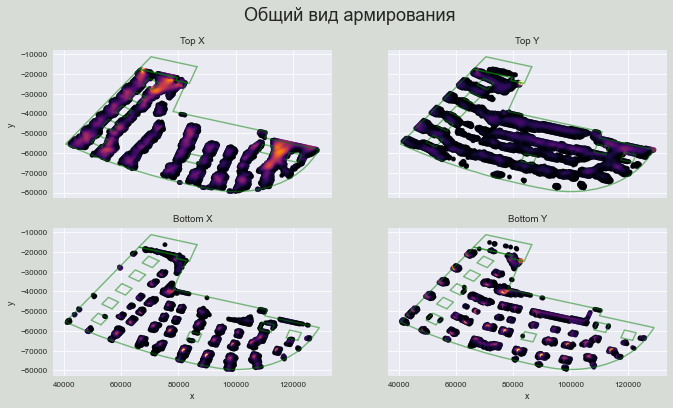

In [8]:
fig, ax = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(11, 6))
for ax_i, color, name in zip([ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]],
                             ['top_x', 'top_y', 'bot_x', 'bot_y'],
                             ['Top X', 'Top Y', 'Bottom X', 'Bottom Y']):
    reinforces_df.plot(x='x', y='y', c=color, ax=ax_i,
              kind='scatter', colormap='inferno', colorbar=False,
              title=name, sharey='all')
    print_slab(slabs, ax_i, color='g')

fig.set_facecolor('#d8dcd6')
fig.suptitle('Общий вид армирования', fontsize=18)

plt.show()

#### Кластеризация

In [9]:
def get_clusters_and_noise_from_type(reinforces_df_,reinforce_type):
    reinforce = reinforces_df_.loc[reinforces_df_[reinforce_type].notna(), ['x', 'y', reinforce_type]]
    db_clustering  = DBSCAN(eps=1000, min_samples=4, n_jobs=-1).fit(reinforce[['x', 'y']])

    labels_ = db_clustering.labels_
    n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)
    n_noise_ = list(labels_).count(-1)

    print(f'{reinforce_type}. Get {len(reinforce)} points -> Covert to {n_clusters_} clusters and {n_noise_} noise points')
    return labels_.astype(pd.Int64Dtype)

for reinf_type in ['top_x', 'top_y', 'bot_x', 'bot_y']:
    labels = get_clusters_and_noise_from_type(reinforces_df, reinf_type)

    reinf_type_label = reinf_type + '_label'
    reinforces_df.loc[reinforces_df[reinf_type].notna(), reinf_type_label] = labels

reinforces_df

top_x. Get 4610 points -> Covert to 11 clusters and 11 noise points
top_y. Get 4980 points -> Covert to 10 clusters and 17 noise points
bot_x. Get 1806 points -> Covert to 43 clusters and 32 noise points
bot_y. Get 1655 points -> Covert to 44 clusters and 41 noise points


,x,y,top_x,top_y,bot_x,bot_y,top_x_label,top_y_label,bot_x_label,bot_y_label
0,66170.0,-17522.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,66478.0,-17619.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66555.0,-16953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67139.0,-16088.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67453.0,-16187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
11651,79358.0,-21671.0,4.57,NaN,8.60,10.88,0,NaN,0,2
11652,79548.0,-22086.0,0.96,0.13,12.13,11.85,0,-1,0,2
11653,79320.0,-21953.0,5.53,NaN,11.72,13.94,0,NaN,0,2
11654,79649.0,-21763.0,0.08,4.38,7.91,12.04,0,-1,0,2


#### Визуализируем кластеры

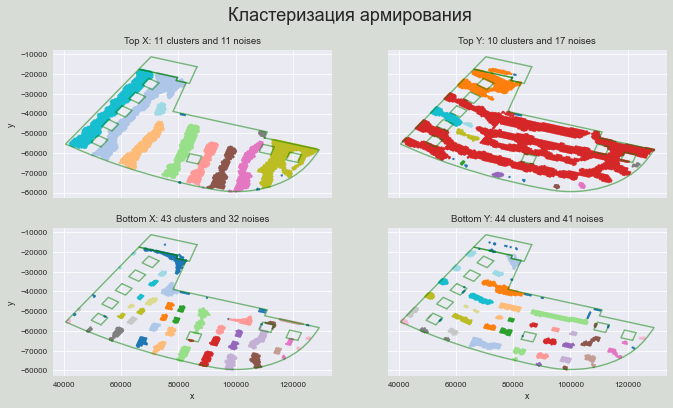

In [10]:
fig, ax = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(11, 6))
for ax_i, column, title in zip([ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]],
                             ['top_x_label', 'top_y_label', 'bot_x_label', 'bot_y_label'],
                             ['Top X', 'Top Y', 'Bottom X', 'Bottom Y']):
    counts = reinforces_df[column].value_counts(sort=False)
    count_noise = counts[-1]
    count_cluster = len(counts) - (1 if count_noise else 0)

    reinforces_df.plot(x='x', y='y', c=column, ax=ax_i, s=4,
              kind='scatter', colormap='tab20', colorbar=False,
              title=title+f': {count_cluster} clusters and {count_noise} noises', sharey='all')
    print_slab(slabs, ax_i, color='g')

fig.set_facecolor('#d8dcd6')
fig.suptitle('Кластеризация армирования', fontsize=18)

plt.show()

### Формируем контуры

Идея: https://pypi.org/project/alphashape/

In [11]:
ALPHA = 0.002  # Влияет на степень сглаживания
contours_all = {'top_x': [], 'top_y': [], 'bot_x': [], 'bot_y': []}
log = []
error = []

for reinf_type in contours_all:
    reinf_type_label = reinf_type + '_label'
    uniq_values = reinforces_df[reinf_type_label].value_counts(sort=False)[:-1]
    for i in uniq_values.index:
        cluster_ = reinforces_df.loc[reinforces_df[reinf_type_label] == i, ['x', 'y']]
        try:
            alpha_shape = alphashape.alphashape(cluster_.to_numpy(), ALPHA)
            if alpha_shape and hasattr(alpha_shape, 'exterior'):
                contours_all[reinf_type].append(tuple(alpha_shape.exterior.coords))
            else:
                log.append((reinf_type, i, alpha_shape, ALPHA))
        except scipy.spatial.qhull.QhullError:
            error.append((reinf_type, i, alpha_shape, ALPHA))

print('Passed:', len(log))
print('Big error:', len(error))

Passed: 8
Big error: 1


#### Визуализируем контуры

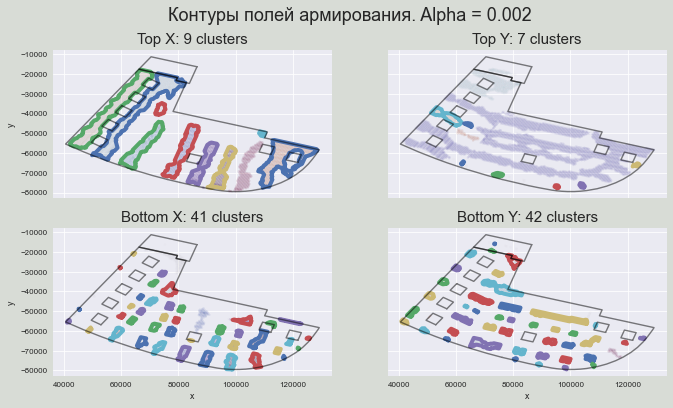

In [12]:
fig, ax = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(11, 6))
for ax_i, column, title in zip([ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]],
                             ['top_x', 'top_y', 'bot_x', 'bot_y'],
                             ['Top X', 'Top Y', 'Bottom X', 'Bottom Y']):
    for contour in contours_all[column]:
        ax_i.plot(*zip(*contour), linewidth=4)

    reinforces_df.plot(x='x', y='y', c=column+'_label', ax=ax_i, s=4,
              kind='scatter', colormap='twilight', colorbar=False, sharey='all', alpha=0.1)
    ax_i.set_title(f'{title}: {len(contours_all[column])} clusters', fontsize=15)
    print_slab(slabs, ax_i, color='black')

fig.set_facecolor('#d8dcd6')
fig.suptitle(f'Контуры полей армирования. Alpha = {ALPHA}', fontsize=18)

plt.show()

#### Записываем внешние контуры

In [13]:
dxf_doc.layers.new('top_x', dxfattribs={'color': 4})
dxf_doc.layers.new('top_y', dxfattribs={'color': 5})
dxf_doc.layers.new('bot_x', dxfattribs={'color': 1})
dxf_doc.layers.new('bot_y', dxfattribs={'color': 2})

for reinf_type, contours in contours_all.items():
    for contour in contours:
        msp.add_lwpolyline(contour, dxfattribs={'layer': reinf_type, 'closed': True})

#### Сохраняем dxf файл

In [14]:
dxf_doc.saveas(PATH_TO_SAVE_DXF)